In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense, Flatten
from keras.layers import LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.initializers import Constant
from keras.layers import *

import os
import pandas as pd
import numpy as np
from numpy import array
import re

Using TensorFlow backend.


In [4]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

df = pd.concat([dff[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex', 'text', 'y_sentence']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_sentence'])
df = df[df['y_sentence'] < 481]

In [5]:
X = df.drop('y_sentence', axis=1)
y = df['y_sentence']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

X4_train =  X_train[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]
X4_test =  X_test[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]

In [8]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 128

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = pad_sequences(X3_train, sequence_length)
X3_test = pad_sequences(X3_test, sequence_length)

In [9]:
input_1 = Input(shape=(687,))
input_2 = Input(shape=(662,))
input_4 = Input(shape=(6,))

dense_layer_1_1 = Dense(100, activation='relu')(input_1)
dense_layer_1_2 = Dense(100, activation='relu')(dense_layer_1_1)
dense_layer_1_3 = Dense(100, activation='relu')(dense_layer_1_2)
dense_layer_1_4 = Dense(10, activation='relu')(dense_layer_1_3)
dropout_1_5 = Dropout(0.2)(dense_layer_1_4)


dense_layer_2_1 = Dense(100, activation='relu')(input_2)
dense_layer_2_2 = Dense(100, activation='relu')(dense_layer_2_1)
dense_layer_2_3 = Dense(100, activation='relu')(dense_layer_2_2)
dense_layer_2_4 = Dense(10, activation='relu')(dense_layer_2_3)
dropout_2_5 = Dropout(0.2)(dense_layer_2_4)

dense_layer_4_1 = Dense(100, activation='relu')(input_4)
dense_layer_4_2 = Dense(100, activation='relu')(dense_layer_4_1)
dense_layer_4_3 = Dense(100, activation='relu')(dense_layer_4_2)
dense_layer_4_4 = Dense(10, activation='relu')(dense_layer_4_3)
dropout_4_5 = Dropout(0.2)(dense_layer_4_4)

In [10]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0814t.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 128
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

23324


In [11]:
input_3 = Input(shape=(sequence_length,), dtype='int32')
embedding_layer_3 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_1_3 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_2_3 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)
conv_3_3 = Conv2D(num_filters, kernel_size=(6, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape_3)

maxpool_0_3 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)
maxpool_3_3 = MaxPool2D(pool_size=(sequence_length - 6 + 1, 1), strides=(1,1), padding='valid')(conv_3_3)

concatenated_tensor_3 = Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3, maxpool_3_3])
flatten_3 = Flatten()(concatenated_tensor_3)
dropout_3 = Dropout(0.5)(flatten_3)

In [12]:
concat_layer = Concatenate()([dropout_1_5, dropout_2_5, dropout_3, dropout_4_5])

dense_layer_3 = Dense(10, activation='relu')(concat_layer)
dense_layer_4 = Dense(10, activation='relu')(dense_layer_3)
dense_layer_5 = Dense(10, activation='relu')(dense_layer_4)
dense_layer_6 = Dense(10, activation='relu')(dense_layer_5)

output = Dense(1, activation='linear')(dense_layer_3)

model = Model(inputs=[input_1, input_2, input_3, input_4], outputs=output)

In [13]:
model.compile(loss='mse', optimizer='Adamax', metrics=['mse', 'mae', 'mape', 'cosine'])
print(model.summary())
#Adamax

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 128)     2985472     input_4[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 687)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 662)          0                                            
____________________________________________________________________________________________

In [14]:
history = model.fit(x=[X1_train, X2_train, X3_train, X4_train], y=y_train, batch_size=16, epochs=50, 
                   verbose=1, validation_split=0.1)# , callbacks=[early_stopping])

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3193 samples, validate on 355 samples
Epoch 1/50
3193/3193 [==============================] - 4s 1ms/step - loss: 1551.2621 - mse: 1502.6248 - mae: 19.4743 - mape: 2526397952.0000 - cosine: 0.8418 - val_loss: 1139.4648 - val_mse: 1075.3969 - val_mae: 18.4341 - val_mape: 3198702080.0000 - val_cosine: 0.8254
Epoch 2/50
3193/3193 [==============================] - 2s 683us/step - loss: 1266.2376 - mse: 1192.1990 - mae: 17.8430 - mape: 2304690176.0000 - cosine: 0.7917 - val_loss: 1062.3404 - val_mse: 975.4789 - val_mae: 17.2797 - val_mape: 2568554752.0000 - val_cosine: 0.7859
Epoch 3/50
3193/3193 [==============================] - 2s 680us/step - loss: 1152.1890 - mse: 1058.0344 - mae: 17.1487 - mape: 2107657600.0000 - cosine: 0.7579 - val_loss: 1028.1044 - val_mse: 928.7767 - val_mae: 16.4167 - val_mape: 2298824704.0000 - val_cosine: 0.8085
Epoch 4/50
3193/3193 [==============================] - 2s 691us/step - loss: 1069.0010 - mse: 960.9997 - mae: 16.3394 - mape: 1974669056.000

3193/3193 [==============================] - 2s 692us/step - loss: 288.5236 - mse: 121.5740 - mae: 7.3939 - mape: 869625600.0000 - cosine: 0.8024 - val_loss: 913.7485 - val_mse: 747.4542 - val_mae: 14.4320 - val_mape: 1862186368.0000 - val_cosine: 0.7859
Epoch 32/50
3193/3193 [==============================] - 2s 690us/step - loss: 279.8184 - mse: 116.5214 - mae: 7.5217 - mape: 926004416.0000 - cosine: 0.8049 - val_loss: 879.9740 - val_mse: 718.6522 - val_mae: 14.4295 - val_mape: 1796278784.0000 - val_cosine: 0.7521
Epoch 33/50
3193/3193 [==============================] - 2s 685us/step - loss: 299.1018 - mse: 138.2502 - mae: 7.7205 - mape: 913663488.0000 - cosine: 0.7867 - val_loss: 912.5830 - val_mse: 747.1495 - val_mae: 17.1548 - val_mape: 2912567552.0000 - val_cosine: 0.8310
Epoch 34/50
3193/3193 [==============================] - 2s 687us/step - loss: 274.4699 - mse: 111.2509 - mae: 7.1919 - mape: 939587328.0000 - cosine: 0.8068 - val_loss: 832.8101 - val_mse: 673.4529 - val_mae: 1

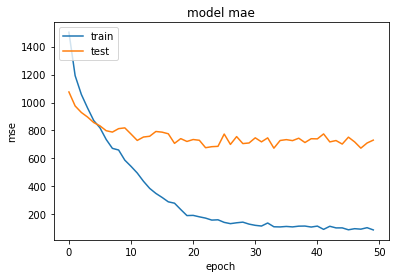

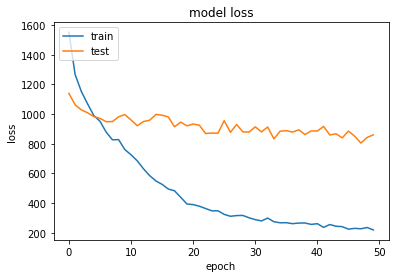

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mae')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [16]:
score = model.evaluate(x=[X1_test, X2_test, X3_test, X4_test], y=y_test, verbose=1)
print(score)
print("Test Score:", score[0])
print("Test MSE:", score[1])
#print("Test MAE: ", score[2])

395/395 [==============================] - 0s 643us/step
[481.3485849114913, 352.21942138671875, 11.531553268432617, 1806861056.0, 0.7189873456954956]
Test Score: 481.3485849114913
Test MSE: 352.21942138671875


In [17]:
#0.1 48미만 112 